<a href="https://colab.research.google.com/github/Frederica97/colornerf/blob/main/clipnerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://www.scenerepresentations.org/assets/logo/logo+text-negative@2x.png" alt="TODO: make logo work better on Colab background" width="212"/>](https://www.scenerepresentations.org)

[`MIT 6.S980, Machine Learning for Inverse Graphics`](https://www.scenerepresentations.org/courses/inverse-graphics/)
# Homework 4: Clip NeRF

### Simple Experiment Requirement
- A dataset with a similar input-output behavior as the final dataset that
you will use in your project. Query a single batch from your dataset and plot
an element of that batch.
- For any kind of single-scene overfitting method, such as NeRF, we would expect the dataset to be a dataset that yields an image, camera intrinsic parameters, and camera extrinsic parameters, and we would expect you to plot an image as well as plot or print the camera pose and intrinsic parameters.
- For a single-scene overfitting (NeRF-like) method, the model could take the camera extrinsics and intrinsics as input, compute the corresponding rays, and query points along each ray.
- A simple training loop, including a loss function, that can be executed to
train your model.


### Goal
Edit the material and color of a NeRF with a input reference image.

### Input
There are two parts of input. The first part is a set of inital images with camera pose, intrinsic parameters, extrinsic parameters. They are used to generate the NeRF latent model. The second part is a reference image of a same type of object that we will learn from its material and color.

## Output
3 images generated from the edited NeRF, with mapped material and color.

# Setup

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install git+https://github.com/openai/CLIP.git
!pip install --upgrade kornia

Looking in indexes: https://download.pytorch.org/whl/cu121
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6_q038nl
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6_q038nl
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369500 sha256=1f3d1df09aa33748988f4274193487a7278ff1239e5f4bcc866a1fc0c196518e
  Stored in directory: /tmp/pip-ephem-wheel-cache-4illnfp1/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.10
    Uninstalling wcwidth-0.2.10:
      Successfully uninstalled wcwidth-0.2.10


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 10.5 MB/s eta 0:00:00


In [2]:
%cd /content
!git clone https://github.com/Frederica97/colornerf.git
%cd /content/colornerf
!pip install -r requirements.txt

/content
Cloning into 'colornerf'...
remote: Enumerating objects: 1504, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1504 (delta 0), reused 1 (delta 0), pack-reused 1501
Receiving objects: 100% (1504/1504), 448.38 MiB | 13.54 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Updating files: 100% (1447/1447), done.
/content/colornerf


In [3]:
import os
import imageio
import time
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm, trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
np.random.seed(0)
DEBUG = False

Using device: cuda


## Part 1.1: Load Data

Load NeRF data with image, camera pose, and intrinsic param information, using the load_blender_data function.

In [4]:
from load_blender import load_blender_data

def loadData():
    datadir = "./data/nerf_synthetic/lego"
    half_res = True
    testskip = 8
    white_bkgd = True

    # Load data
    K = None
    images, poses, render_poses, hwf, i_split = load_blender_data(datadir, half_res, testskip)
    print('Loaded blender', images.shape, render_poses.shape, hwf, datadir)
    i_train, i_val, i_test = i_split

    if white_bkgd:
        images = images[...,:3]*images[...,-1:] + (1.-images[...,-1:])
    else:
        images = images[...,:3]

    # intrinsics param
    H, W, focal = hwf
    H, W = int(H), int(W)
    hwf = [H, W, focal]

    if K is None:
        K = np.array([
            [focal, 0, 0.5*W],
            [0, focal, 0.5*H],
            [0, 0, 1]
        ])

    print('intrinsic param: \n', K)
    print('camera pose: \n', poses[0])

    plt.imshow(images[0])
    plt.show()
    return images, K, poses, render_poses, hwf, i_train, i_val, i_test


## Part 1.2: Create NeRF


In [5]:
from run_nerf_helpers import get_embedder
from run_nerf_clip import run_network

def create_nerf(N_importance = 0):

    use_viewdirs = True

    input_ch_views = 0
    embeddirs_fn = None

    multires = 10
    multires_views = 4
    i_embed = 0
    embed_fn, input_ch = get_embedder(multires, i_embed)
    if use_viewdirs:
        embeddirs_fn, input_ch_views = get_embedder(multires_views, i_embed)
    output_ch = 5 if N_importance > 0 else 4

    skips = [4]
    netdepth = 8 # layers in the network
    netwidth = 256 # channels per layer
    netchunk = 1024*64

    model = NeRF(D=netdepth, W=netwidth,
                 input_ch=input_ch, output_ch=output_ch, skips=skips,
                 input_ch_views=input_ch_views, use_viewdirs=use_viewdirs).to(device)
    grad_vars = list(model.parameters())

    model_fine = None
    network_query_fn = lambda inputs, viewdirs, network_fn : run_network(inputs, viewdirs, network_fn,
                                                                embed_fn=embed_fn,
                                                                embeddirs_fn=embeddirs_fn,
                                                                netchunk=netchunk)

    #optimizer = torch.optim.Adam(params=grad_vars, lr=args.lrate, betas=(0.9, 0.999)) # original NeRF optimizer
    lrate = 5e-4
    optimizer = torch.optim.Adam(grad_vars, lr=lrate, betas=(0.9, 0.999))

    start = 0
    perturb = 1 # set to 0. for no jitter, 1. for jitter
    white_bkgd = True
    N_samples = 64
    raw_noise_std = 0 # std dev of noise added to regularize sigma_a output, 1e0 recommended


    ft_path = "./checkpoint/2000000.tar"
    ##########################

    # Load checkpoints
    if ft_path is not None and ft_path!='None':
        ckpts = [ft_path]
    else:
        ckpts = [os.path.join(basedir, expname, f) for f in sorted(os.listdir(os.path.join(basedir, expname))) if 'tar' in f]

    print('Found ckpts', ckpts)
    if len(ckpts) > 0 and not args.no_reload:
        ckpt_path = ckpts[-1]
        print('Reloading from', ckpt_path)
        ckpt = torch.load(ckpt_path)

        start = ckpt['global_step']
        # use new optimizer .............
        #optimizer.load_state_dict(ckpt['optimizer_state_dict'])

        # Load model
        model.load_state_dict(ckpt['network_fn_state_dict'])
        if model_fine is not None:
            model_fine.load_state_dict(ckpt['network_fine_state_dict'])

    ##########################



    # Prepare raybatch tensor if batching random rays
    render_kwargs_train = {
        'network_query_fn' : network_query_fn,
        'perturb' : perturb,
        'N_importance' : N_importance,
        'network_fine' : model_fine,
        'N_samples' : N_samples,
        'network_fn' : model,
        'use_viewdirs' : use_viewdirs,
        'white_bkgd' : white_bkgd,
        'raw_noise_std' : raw_noise_std,
    }

    dataset_type = "blender"
    basedir = './logs'
    expname = "blender_paper_lego"
    lindisp = True

    # NDC only good for LLFF-style forward facing data
    if dataset_type != 'llff':
        print('Not ndc!')
        render_kwargs_train['ndc'] = False
        render_kwargs_train['lindisp'] = lindisp # sampling linearly in disparity rather than depth

    render_kwargs_test = {k : render_kwargs_train[k] for k in render_kwargs_train}
    render_kwargs_test['perturb'] = False
    render_kwargs_test['raw_noise_std'] = 0.



    return render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer



In [6]:
# Model
class NeRF(nn.Module):
    def __init__(self, D=8, W=256, input_ch=3, input_ch_views=3, output_ch=4, skips=[4], use_viewdirs=False):
        """
        """
        super(NeRF, self).__init__()
        self.D = D
        self.W = W
        self.input_ch = input_ch
        self.input_ch_views = input_ch_views
        self.skips = skips
        self.use_viewdirs = use_viewdirs

        self.pts_linears = nn.ModuleList(
                [nn.Linear(input_ch, W)] + [nn.Linear(W, W) if i not in self.skips else nn.Linear(W + input_ch, W) for i in range(D-1)])

        ### Implementation according to the official code release (https://github.com/bmild/nerf/blob/master/run_nerf_helpers.py#L104-L105)
        self.views_linears = nn.ModuleList([nn.Linear(input_ch_views + W, W//2)])

        ### Implementation according to the paper
        # self.views_linears = nn.ModuleList(
        #     [nn.Linear(input_ch_views + W, W//2)] + [nn.Linear(W//2, W//2) for i in range(D//2)])

        if use_viewdirs:
            self.feature_linear = nn.Linear(W, W)
            self.alpha_linear = nn.Linear(W, 1)
            self.rgb_linear = nn.Linear(W//2, 3)
        else:
            self.output_linear = nn.Linear(W, output_ch)

    def forward(self, x):
        input_pts, input_views = torch.split(x, [self.input_ch, self.input_ch_views], dim=-1)
        h = input_pts
        for i, l in enumerate(self.pts_linears):
            h = self.pts_linears[i](h)
            h = F.relu(h)
            if i in self.skips:
                h = torch.cat([input_pts, h], -1)

        if self.use_viewdirs:
            alpha = self.alpha_linear(h)
            feature = self.feature_linear(h)
            h = torch.cat([feature, input_views], -1)

            for i, l in enumerate(self.views_linears):
                h = self.views_linears[i](h)
                h = F.relu(h)

            rgb = self.rgb_linear(h)
            outputs = torch.cat([rgb, alpha], -1)
        else:
            outputs = self.output_linear(h)

        return outputs

    def load_weights_from_keras(self, weights):
        assert self.use_viewdirs, "Not implemented if use_viewdirs=False"

        # Load pts_linears
        for i in range(self.D):
            idx_pts_linears = 2 * i
            self.pts_linears[i].weight.data = torch.from_numpy(np.transpose(weights[idx_pts_linears]))
            self.pts_linears[i].bias.data = torch.from_numpy(np.transpose(weights[idx_pts_linears+1]))

        # Load feature_linear
        idx_feature_linear = 2 * self.D
        self.feature_linear.weight.data = torch.from_numpy(np.transpose(weights[idx_feature_linear]))
        self.feature_linear.bias.data = torch.from_numpy(np.transpose(weights[idx_feature_linear+1]))

        # Load views_linears
        idx_views_linears = 2 * self.D + 2
        self.views_linears[0].weight.data = torch.from_numpy(np.transpose(weights[idx_views_linears]))
        self.views_linears[0].bias.data = torch.from_numpy(np.transpose(weights[idx_views_linears+1]))

        # Load rgb_linear
        idx_rbg_linear = 2 * self.D + 4
        self.rgb_linear.weight.data = torch.from_numpy(np.transpose(weights[idx_rbg_linear]))
        self.rgb_linear.bias.data = torch.from_numpy(np.transpose(weights[idx_rbg_linear+1]))

        # Load alpha_linear
        idx_alpha_linear = 2 * self.D + 6
        self.alpha_linear.weight.data = torch.from_numpy(np.transpose(weights[idx_alpha_linear]))
        self.alpha_linear.bias.data = torch.from_numpy(np.transpose(weights[idx_alpha_linear+1]))


In [7]:
# create_nerf()

## Part 1.3: Render function

Prepare a render function to render in batch.

In [8]:
from run_nerf_clip import batchify_rays
from run_nerf_helpers import get_rays, ndc_rays

def render(H, W, K, chunk=1024*32, rays=None, c2w=None, ndc=True,
                  near=0., far=1.,
                  use_viewdirs=False, c2w_staticcam=None,
                  **kwargs):
    """Render rays
    Args:
      H: int. Height of image in pixels.
      W: int. Width of image in pixels.
      focal: float. Focal length of pinhole camera.
      chunk: int. Maximum number of rays to process simultaneously. Used to
        control maximum memory usage. Does not affect final results.
      rays: array of shape [2, batch_size, 3]. Ray origin and direction for
        each example in batch.
      c2w: array of shape [3, 4]. Camera-to-world transformation matrix.
      ndc: bool. If True, represent ray origin, direction in NDC coordinates.
      near: float or array of shape [batch_size]. Nearest distance for a ray.
      far: float or array of shape [batch_size]. Farthest distance for a ray.
      use_viewdirs: bool. If True, use viewing direction of a point in space in model.
      c2w_staticcam: array of shape [3, 4]. If not None, use this transformation matrix for
       camera while using other c2w argument for viewing directions.
    Returns:
      rgb_map: [batch_size, 3]. Predicted RGB values for rays.
      disp_map: [batch_size]. Disparity map. Inverse of depth.
      acc_map: [batch_size]. Accumulated opacity (alpha) along a ray.
      extras: dict with everything returned by render_rays().
    """
    if c2w is not None:
        # special case to render full image
        rays_o, rays_d = get_rays(H, W, K, c2w)
    else:
        # use provided ray batch
        rays_o, rays_d = rays

    if use_viewdirs:
        # provide ray directions as input
        viewdirs = rays_d
        if c2w_staticcam is not None:
            # special case to visualize effect of viewdirs
            rays_o, rays_d = get_rays(H, W, K, c2w_staticcam)
        viewdirs = viewdirs / torch.norm(viewdirs, dim=-1, keepdim=True)
        viewdirs = torch.reshape(viewdirs, [-1,3]).float()

    sh = rays_d.shape # [..., 3]
    if ndc:
        # for forward facing scenes
        rays_o, rays_d = ndc_rays(H, W, K[0][0], 1., rays_o, rays_d)

    # Create ray batch
    rays_o = torch.reshape(rays_o, [-1,3]).float()
    rays_d = torch.reshape(rays_d, [-1,3]).float()

    near, far = near * torch.ones_like(rays_d[...,:1]), far * torch.ones_like(rays_d[...,:1])
    rays = torch.cat([rays_o, rays_d, near, far], -1)
    if use_viewdirs:
        rays = torch.cat([rays, viewdirs], -1)

    # Render and reshape
    all_ret = batchify_rays(rays, chunk, **kwargs)
    for k in all_ret:
        k_sh = list(sh[:-1]) + list(all_ret[k].shape[1:])
        all_ret[k] = torch.reshape(all_ret[k], k_sh)

    k_extract = ['rgb_map', 'disp_map', 'acc_map']
    ret_list = [all_ret[k] for k in k_extract]
    ret_dict = {k : all_ret[k] for k in all_ret if k not in k_extract}
    return ret_list + [ret_dict]

In [9]:
def render_path(render_poses, hwf, K, chunk, render_kwargs, gt_imgs=None, savedir=None, render_factor=0):

    H, W, focal = hwf

    if render_factor!=0:
        # Render downsampled for speed
        H = H//render_factor
        W = W//render_factor
        focal = focal/render_factor

    rgbs = []
    disps = []

    t = time.time()
    for i, c2w in enumerate(tqdm(render_poses)):
        # print(i, time.time() - t)
        t = time.time()
        rgb, disp, acc, _ = render(H, W, K, chunk=chunk, c2w=c2w[:3,:4], **render_kwargs)
        rgbs.append(rgb.cpu().numpy())
        disps.append(disp.cpu().numpy())
        if i==0:
            print(rgb.shape, disp.shape)

        """
        if gt_imgs is not None and render_factor==0:
            p = -10. * np.log10(np.mean(np.square(rgb.cpu().numpy() - gt_imgs[i])))
            print(p)
        """

        if savedir is not None:
            rgb8 = to8b(rgbs[-1])
            filename = os.path.join(savedir, '{:03d}.png'.format(i))
            imageio.imwrite(filename, rgb8)


    rgbs = np.stack(rgbs, 0)
    disps = np.stack(disps, 0)

    return rgbs, disps

## Part 2: Clip

In [10]:
import clip

class CLIPLoss(torch.nn.Module):

    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")
        #self.upsample = torch.nn.Upsample(scale_factor=7)
        #self.avg_pool = torch.nn.AvgPool2d(kernel_size=opts.stylegan_size // 32)

    def forward(self, image, text):
        image = torch.nn.functional.interpolate(image, size=(224, 224), mode='bilinear', align_corners=False)
        #image = self.avg_pool(self.upsample(image))
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity#.mean()


## Part 3: Clip Nerf

### Part 3.1: Train


In [11]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img2mse = lambda x, y : torch.mean((x - y) ** 2).to(device)
mse2psnr = lambda x : -10. * torch.log(x) / torch.log(torch.Tensor([10.])).to(device)
to8b = lambda x : (255*np.clip(x,0,1)).astype(np.uint8)

In [33]:
from run_nerf_helpers import get_rays_np
from run_nerf_clip import get_select_inds
import kornia


def train():
    images, K, poses, render_poses, hwf, i_train, i_val, i_test  = loadData()
    H, W, focal = hwf
    H, W = int(H), int(W)

    # Create nerf model
    render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer = create_nerf()
    global_step = start

    bds_dict = {
        'near' : 2,
        'far' : 6,
    }
    render_kwargs_train.update(bds_dict)
    render_kwargs_test.update(bds_dict)

    # Move testing data to GPU
    render_poses = torch.Tensor(render_poses).to(device)

    # Prepare raybatch tensor if batching random rays
    N_rand = 32*32*4
    N_iters = 5001 + 1

    # For random ray batching
    rays = np.stack([get_rays_np(H, W, K, p) for p in poses[:,:3,:4]], 0) # [N, ro+rd, H, W, 3]
    rays_rgb = np.concatenate([rays, images[:,None]], 1) # [N, ro+rd+rgb, H, W, 3]
    rays_rgb = np.transpose(rays_rgb, [0,2,3,1,4]) # [N, H, W, ro+rd+rgb, 3]
    rays_rgb = np.stack([rays_rgb[i] for i in i_train], 0) # train images only
    rays_rgb = np.reshape(rays_rgb, [-1,3,3]) # [(N-1)*H*W, ro+rd+rgb, 3]
    rays_rgb = rays_rgb.astype(np.float32)
    np.random.shuffle(rays_rgb)

    i_batch = 0

    # Move training data to GPU
    images = torch.Tensor(images).to(device)
    poses = torch.Tensor(poses).to(device)
    rays_rgb = torch.Tensor(rays_rgb).to(device)



    print('Begin')
    print('TRAIN views are', i_train)
    print('TEST views are', i_test)
    print('VAL views are', i_val)

    basedir = "./logs"
    expname = "blender_paper_lego"

    description = "A pink excavator"
    sample_scale = 60
    chunk = 1024*32
    w_clip = 1.0
    use_clip = True
    lrate = 5e-4
    lrate_decay = 250

    # logging/saving options
    i_weights = 500
    i_testset = 1000
    i_print = 500

    # CLIP loss
    text_inputs = torch.cat([clip.tokenize(description)])
    clip_loss = CLIPLoss()

    start = start + 1

    for i in trange(start, N_iters):
        # Sample random ray batch
        # Random over all images
        batch = rays_rgb[i_batch:i_batch+N_rand] # [B, 2+1, 3*?]
        batch = torch.transpose(batch, 0, 1)
        batch_rays, target_s = batch[:2], batch[2]

        # print ("Random over all images:", target_s.shape)

        i_batch += N_rand
        if i_batch >= rays_rgb.shape[0]:
            print("Shuffle data after an epoch!")
            rand_idx = torch.randperm(rays_rgb.shape[0])
            rays_rgb = rays_rgb[rand_idx]
            i_batch = 0

        else:
            # Random from one image
            img_i = np.random.choice(i_train)
            target = images[img_i]
            target = torch.Tensor(target).to(device)
            pose = poses[img_i, :3,:4]

            rays_o, rays_d = get_rays(H, W, K, torch.Tensor(pose))  # (H, W, 3), (H, W, 3)

            select_inds = get_select_inds(sample_scale * sample_scale, i)

            rays_o = torch.nn.functional.grid_sample(rays_o.permute(2, 0, 1).unsqueeze(0),
                                                     select_inds.unsqueeze(0), mode='bilinear', align_corners=True)[0]
            rays_d = torch.nn.functional.grid_sample(rays_d.permute(2, 0, 1).unsqueeze(0),
                                                     select_inds.unsqueeze(0), mode='bilinear', align_corners=True)[0]
            rays_o = rays_o.permute(1, 2, 0).view(-1, 3)
            rays_d = rays_d.permute(1, 2, 0).view(-1, 3)

            target_s = torch.nn.functional.grid_sample(target.permute(2, 0, 1).unsqueeze(0),
                                                     select_inds.unsqueeze(0), mode='bilinear', align_corners=True)[0]
            target_s = target_s.permute(1, 2, 0).view(-1, 3)

            batch_rays = torch.stack([rays_o, rays_d], 0)

        # Optimization loop
        rgb, disp, acc, extras = render(H, W, K, chunk=chunk, rays=batch_rays,
                                                verbose=i < 10, retraw=True,
                                                **render_kwargs_train)

        rgb_img = rgb.view(sample_scale, sample_scale, -1)
        target = target_s.view(sample_scale, sample_scale, -1)
        rgb_img = rgb_img.permute(2,0,1).unsqueeze(0)
        rgb_img_gray = kornia.color.rgb_to_grayscale(rgb_img)
        target_img = target.permute(2,0,1).unsqueeze(0)
        target_img_gray = kornia.color.rgb_to_grayscale(target_img)

        optimizer.zero_grad()

        img_loss = img2mse(rgb_img_gray, target_img_gray)
        loss = img_loss
        psnr = mse2psnr(img_loss)

        if 'rgb0' in extras:
            rgb0_img = extras['rgb0'].view(sample_scale, sample_scale, -1)
            rgb0_img = rgb0_img.permute(2,0,1).unsqueeze(0)
            rgb0_img_gray = kornia.color.rgb_to_grayscale(rgb0_img)
            img_loss0 = img2mse(rgb0_img_gray, target_img_gray)
            loss = loss + img_loss0

        if use_clip:
            gen_img = rgb_img
            c_loss = clip_loss(gen_img, text_inputs)
            loss = loss + c_loss * w_clip

            if 'rgb0' in extras:
                gen_img_rgb0 = extras['rgb0'].view(sample_scale, sample_scale, -1).permute(2,0,1).unsqueeze(0)
                c_loss_rgb0 = clip_loss(gen_img_rgb0, text_inputs)
                loss = loss + c_loss_rgb0 * w_clip

        loss.backward()
        optimizer.step()

        # Update learning rate
        decay_rate = 0.1
        decay_steps = lrate_decay * 1000
        new_lrate = lrate * (decay_rate ** (global_step / decay_steps))
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lrate

        # Rest is logging
        if i%i_weights==0:
            path = os.path.join('/content/drive/MyDrive/clipnerf/', expname, '{:06d}.tar'.format(i))
            torch.save({
                'global_step': global_step,
                'network_fn_state_dict': render_kwargs_train['network_fn'].state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, path)
            print('Saved checkpoints at', path)

        # if i%i_weights==0 and i > 0:
        #     # Turn on testing mode
        #     with torch.no_grad():
        #         rgbs, disps = render_path(render_poses, hwf, K, chunk, render_kwargs_test)
        #     print('Done, saving', rgbs.shape, disps.shape)
        #     moviebase = os.path.join('/content/drive/MyDrive/clipnerf/', expname, '{:06d}_'.format(i))
        #     imageio.mimwrite(moviebase + 'rgb.mp4', to8b(rgbs), fps=30, quality=8)
        #     imageio.mimwrite(moviebase + 'disp.mp4', to8b(disps / np.max(disps)), fps=30, quality=8)

        if i%i_testset==0 and i > 0:
            testsavedir = os.path.join('/content/drive/MyDrive/clipnerf/', expname, 'testset_{:06d}'.format(i))
            os.makedirs(testsavedir, exist_ok=True)
            with torch.no_grad():
                render_path(torch.Tensor(poses[i_test]).to(device), hwf, K, chunk, render_kwargs_test, gt_imgs=images[i_test], savedir=testsavedir)
            print('Saved test set')

        if i%i_print==0:
            if use_clip:
                tqdm.write(f"[TRAIN] Iter: {i} Loss: {loss.item()}  CLoss: {c_loss.item()} PSNR: {psnr.item()}")
            else:
                tqdm.write(f"[TRAIN] Iter: {i} Loss: {loss.item()} PSNR: {psnr.item()}")

        global_step += 1


Loaded blender (138, 400, 400, 4) torch.Size([40, 4, 4]) [400, 400, 555.5555155968841] ./data/nerf_synthetic/lego
intrinsic param: 
 [[555.5555156   0.        200.       ]
 [  0.        555.5555156 200.       ]
 [  0.          0.          1.       ]]
camera pose: 
 [[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


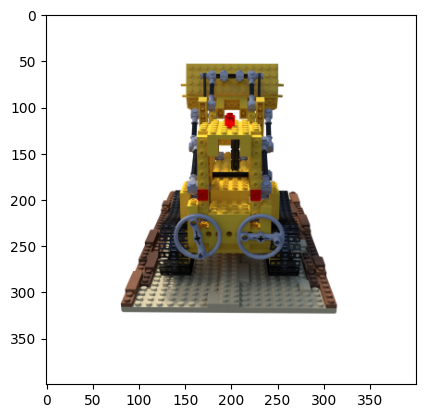

Not ndc!
Begin
TRAIN views are [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
TEST views are [113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137]
VAL views are [100 101 102 103 104 105 106 107 108 109 110 111 112]


 10%|▉         | 500/5001 [06:59<1:03:58,  1.17it/s]

Saved checkpoints at /content/drive/MyDrive/clipnerf/blender_paper_lego/000500.tar


 20%|█▉        | 999/5001 [13:58<57:00,  1.17it/s]

Saved checkpoints at /content/drive/MyDrive/clipnerf/blender_paper_lego/001000.tar



  4%|▍         | 1/25 [00:06<02:27,  6.13s/it]

torch.Size([400, 400, 3]) torch.Size([400, 400])



 20%|█▉        | 1000/5001 [16:32<52:01:20, 46.81s/it]

Saved test set
[TRAIN] Iter: 1000 Loss: 0.90234375  CLoss: 0.8154296875 PSNR: 10.61667251586914


 27%|██▋       | 1366/5001 [21:38<50:45,  1.19it/s]

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
train()

In [ ]:
# !python run_nerf_clip.py --config configs/lego.txt --description "red lego"

###Part 3.2 Plot trained result

In [ ]:
from IPython.display import HTML
from base64 import b64encode

path200 = "/content/drive/MyDrive/clipnerf/blender_paper_lego"
path400 = "blender_paper_lego_spiral_000400_rgb.mp4"
path600 = "blender_paper_lego_spiral_000600_rgb.mp4"


# Function to display the video
def display_video(file_path):
    video_file = open(file_path, 'rb')
    video_contents = video_file.read()
    video_encoded = b64encode(video_contents).decode('ascii')

    # Create HTML code to embed the video
    html_code = f'''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{video_encoded}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    '''

    # Display the HTML code
    display(HTML(html_code))

# Display the video
display_video(path200)
display_video(path400)
display_video(path600)

In [ ]:
from PIL import Image

directory = '/content/drive/MyDrive/clipnerf/blender_paper_lego/testset_000500'

all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
random_files = random.sample(all_files, 3)
fig, axs = plt.subplots(1, 3, figsize=(10, 10))

for i, file in enumerate(random_files):
    file_path = os.path.join(directory, file)

    img = Image.open(file_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f'Image {i + 1}')

plt.show()